In [2]:
# Finite element method for 2D Poisson's equation

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [3]:
# Define the domain and the mesh
xmin, xmax, ymin, ymax = 0, 20e-9, 0, 20e-9
nx = 50
ny = nx
hx, hy = (xmax-xmin)/nx, (ymax-ymin)/ny
x = np.linspace(xmin, xmax, nx+1)
y = np.linspace(ymin, ymax, ny+1)
X, Y = np.meshgrid(x, y)

In [4]:
def lou(phi):
    e0 = 8.85e-12
    e = 1.6e-19
    z = 1
    c0 = 10
    ce = 0
    k = 1.38e-23
    T = 300
    kT = k * T
    rhs = - e * (c0 * np.exp(-z *e* phi / kT) - ce *np.exp(z *e* phi / kT))/e0
    # print(rhs)
    return rhs

In [5]:
elements = []
nodes = []
charge_position = []
for i in range(nx+1):
    for j in range(ny+1):
        if i < nx and j < ny:
            n1 = i*(ny+1) + j
            n2 = (i+1)*(ny+1) + j
            n3 = i*(ny+1) + (j+1)
            n4 = (i+1)*(ny+1) + (j+1)
            elements.append([n1, n2, n3])
            elements.append([n2, n4, n3])
            # if i == (nx+1)//2 and (j == (ny+1)//2):
            #     charge_position.append(len(elements))
            if i == (nx+1)//2 and (j == (ny+1)//3 or j == 2 * (ny+1)//3):
                charge_position.append(len(elements))
        nodes.append([x[i], y[j]])


In [6]:
# Boundary conditions and right-hand side
bc = []
for j in range(ny+1):
    n = j
    bc.append([n, 2])
    n = nx*(ny+1) + j
    bc.append([n, 0])
for i in range(nx+1):
    n = i*(ny+1)
    bc.append([n, 0])
    n = i*(ny+1) + ny
    bc.append([n, 0])

In [7]:
nnodes = len(nodes)
nedges = len(elements)
A = np.zeros([nnodes,nnodes])
F = np.zeros(nnodes)

for e in range(nedges):
    n1, n2, n3 = elements[e]
    x1, y1 = nodes[n1]
    x2, y2 = nodes[n2]
    x3, y3 = nodes[n3]
    position = np.array([[0,1,0],[0,0,1]])
    JF = np.array([[x2-x1, x3-x1], [y2-y1, y3-y1]])
    invJF = np.linalg.inv(JF)
    detJF = np.linalg.det(JF)
    Nabla = np.array([[-1,1,0],[-1,0,1]])
    B = np.dot(invJF.T,Nabla)
    ke = np.dot(B.T,B)*detJF/3
    for i in range(3):
        for j in range(3):
            A[elements[e][i], elements[e][j]] += ke[i,j]
    

for n, val in bc:
    A[n, :] = 0
    A[n, n] = 1

In [8]:
def itteration(u):
    
    F = np.zeros(nnodes)
    for e in range(nedges):
        # position = np.array([[0,1,0],[0,0,1]])
        # Fx = np.dot(JF,position)+np.array([[x1,x1,x1],[y1,y1,y1]]) # (2,3)
        xy = np.array([[0, 0],[1, 0],[0, 1]])
        for x,y in zip(xy[:,0],xy[:,1]):
            basis = np.array([1-x-y,x,y])
            fx = lou(u[elements[e]]) # (3,)
            fe = fx*detJF*basis/3 # (3,)
            for i in range(3):
                F[elements[e][i]] += fe[i]
            if e in charge_position:
                F[elements[e]] += 1
    for n, val in bc:
        F[n] = val
    # print(np.linalg.norm(F))
    u = np.linalg.solve(A, F)
    return u

In [9]:
# u = np.random.rand(nnodes)
u = np.zeros(nnodes)
eps = 1e-5
for _ in tqdm(range(1000)):
    u_old = u
    u = itteration(u_old)
    if np.linalg.norm(u-u_old)<eps:
        break

  0%|          | 1/1000 [00:00<12:10,  1.37it/s]


In [10]:
np.linalg.norm(u-u_old)

0.0

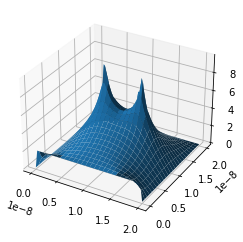

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u.reshape((nx+1, ny+1)))
plt.show()

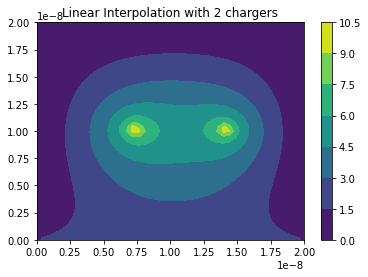

In [12]:
plt.contourf(X,Y,u.reshape((nx+1, ny+1)))
# plt.title(f"Linear Interpolation with nx = {nx}")
plt.title(f"Linear Interpolation with {len(charge_position)} chargers")
plt.colorbar()

/var/folders/g0/6617w89s72vchxjk63ggp5x00000gn/T/ipykernel_5733/2656616829.py:8: RuntimeWarning: divide by zero encountered in log
  color = 2 * np.log(np.hypot(Ex, Ey))


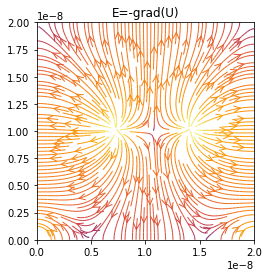

In [17]:
from matplotlib.patches import Circle
U_array = u.reshape((nx+1, ny+1))
Ey, Ex = np.gradient(-U_array)
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Ex, Ey))
ax.streamplot(x, y, Ex, Ey, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: '#aa0000', False: '#0000aa'}
# for q, pos in charges:
#     ax.add_artist(Circle(pos, 0.05, color=charge_colors[q > 0]))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
ax.set_title('E=-grad(U)')
plt.show()